In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import ast

In [3]:
basedir = '../data/jhw_2024-05-13'
fname = "%s/mtn_stavanger_HDBSCAN_25_eval_results_by_shipgroup.csv" % basedir
df = pd.read_csv(fname)
df.head(1).T

,0
Unnamed: 0,0
id,205655000_0_2022-05-07 21:22:02
SSPD,360.925854
distances,"[334.3497420755854, 331.9798104794464, 329.342..."
fraction_covered,0.644552
message,success
path,"[559, 561, 560, 605, 604, 633, 418, 165, 166]"
path_linestring,LINESTRING (283934.52853239886 6551114.9093911...
mmsi,205655000
bredde,30.0


In [4]:
all_evaluation_results_meta = df.copy()

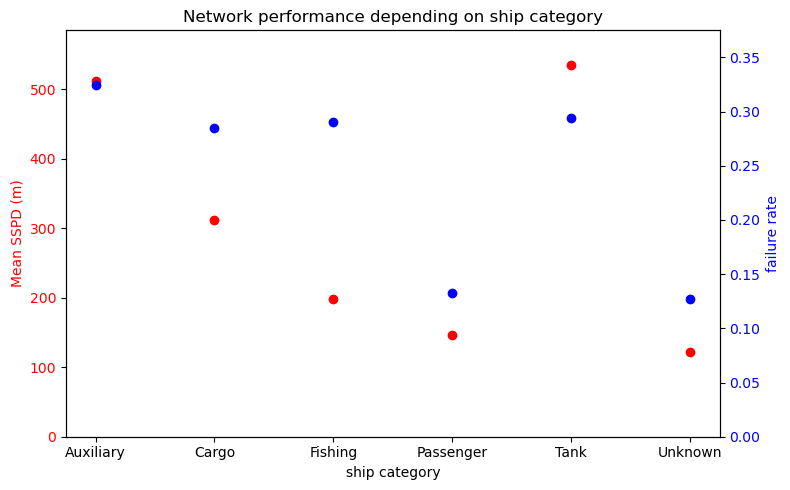

In [5]:
# plot failure rate and MAE by shipgroup
# MAE
mae_by_group = all_evaluation_results_meta.groupby(['skipsgruppe'])['SSPD'].mean()
# Failure rate
success_by_group = all_evaluation_results_meta[all_evaluation_results_meta.message=='success'].groupby(['skipsgruppe'])['message'].count()
msg_by_group = all_evaluation_results_meta.groupby(['skipsgruppe'])['message'].count()
failure_by_group = 1 - success_by_group / msg_by_group
# X-axis
x = mae_by_group.index

# prepare plot and axes
fig, ax1 = plt.subplots(figsize=[8, 5])
ax1.set_xlabel('ship category')
ax1.set_ylabel('Mean SSPD (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax2 = ax1.twinx()
ax2.set_ylabel('failure rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

y1 = mae_by_group.values
y2 = failure_by_group.values

# Set the limits for the y-axes
max_y1_value = max(y1)
max_y2_value = max(y2)
ax1.set_ylim(0, max_y1_value+50)
ax2.set_ylim(0, max_y2_value+0.05)

# plot
ax1.scatter(x, y1, color='red')
ax2.scatter(x, y2, color='blue')

plt.title('Network performance depending on ship category')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('min_samples.png')
# fig.show()

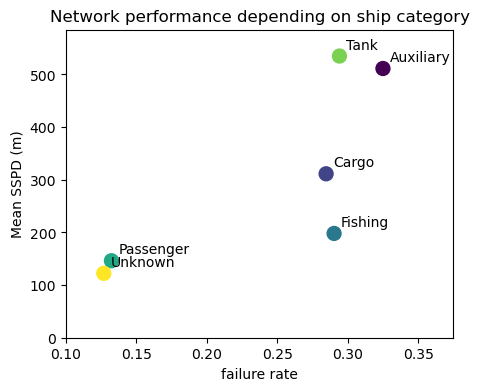

In [6]:
# Visualize MAE and failure rate per ship category in one plot
x = failure_by_group.values
y = mae_by_group.values
categories = mae_by_group.index

fig, ax = plt.subplots(figsize=[5, 4])

# Scatter plot with different colors and markers for each category
scatter = ax.scatter(x, y, c=range(len(categories)), cmap='viridis', marker='o', s=100)

# Annotate each point with the ship category name
for i, category in enumerate(categories):
    ax.annotate(category, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='left')

max_x_value = max(x)
max_y_value = max(y)
ax.set_xlim(0.1, max_x_value+0.05)
ax.set_ylim(0, max_y_value+50)

ax.set_xlabel('failure rate')
ax.set_ylabel('Mean SSPD (m)')
plt.title('Network performance depending on ship category')
plt.savefig('Network_performance_by_ship_category.pdf')

# plt.show()

(0.0, 3000.0)

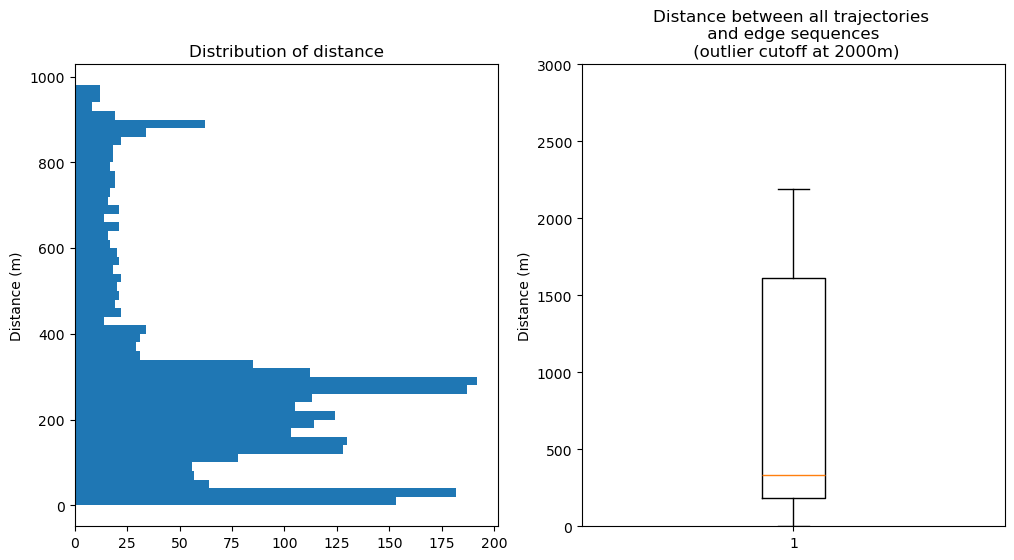

In [7]:
# Plot the distribution of MAE (only for successfully mapped trajectories)
all_evaluation_results = all_evaluation_results_meta
success_mask = all_evaluation_results['message']=='success'
success_eval_results = all_evaluation_results[success_mask]

distances = []
for row in success_eval_results.head(2).itertuples():
    # print(np.array(row.distances).tolist())
    # https://stackoverflow.com/a/23112008/21124232
    distances.extend(ast.literal_eval(row.distances))

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(distances, bins=np.arange(0, 1000, 20).tolist(), orientation='horizontal')
axes[0].set_title('Distribution of distance')
axes[0].set_ylabel('Distance (m)')
    
axes[1].boxplot(distances)
axes[1].set_title('Distance between all trajectories \n and edge sequences \n (outlier cutoff at 2000m)')
axes[1].set_ylabel('Distance (m)')
axes[1].set_ylim([0, 3000])

# #plt.savefig('distance_distribution_oslo.pdf')

# len(distances)

# Do Some Stats

In [8]:
# what's the spread in SSPD?
sspd = all_evaluation_results_meta['SSPD']
sspd = sspd[~np.isnan(sspd)]
sspd.describe()

count     630.000000
mean      193.377388
std       383.908694
min         6.056860
25%        30.835121
50%        57.314276
75%       153.740712
max      2847.070038
Name: SSPD, dtype: float64

<Axes: xlabel='SSPD', ylabel='Count'>

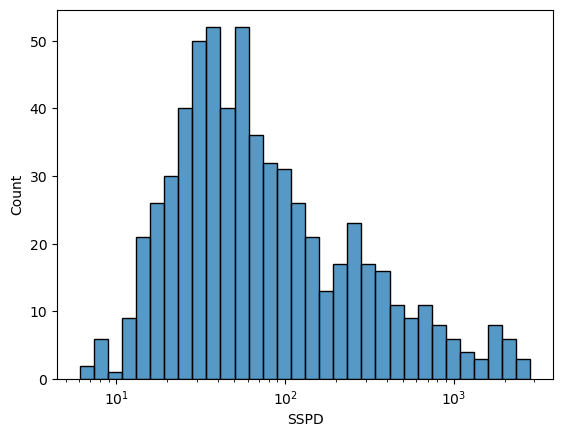

In [9]:
sns.histplot(sspd, bins=32, log_scale=True)

<Axes: ylabel='Count'>

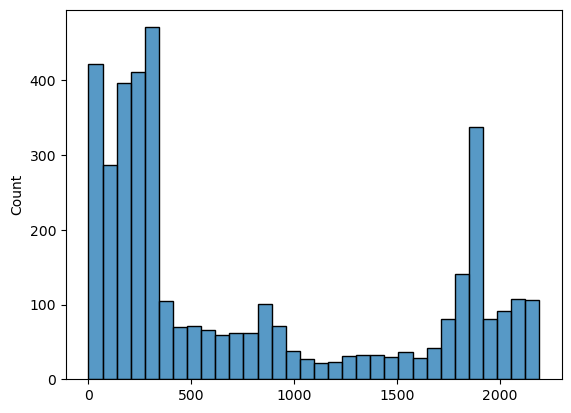

In [10]:
sns.histplot(distances, bins=32, log_scale=False)

In [11]:
# # CDF with percentiles
# fig, axarr = plt.subplots(1,2)
# fig.set_size_inches(8,3)

# ax = axarr[0]
# ax.plot(np.linspace(0,1,len(distances))*100, sorted(distances))
# ax.plot([0,100],[np.mean(distances)]*2, 'k', lw=2)
# ax.set_title('CDF of Distances')
# ax.set_ylabel('Distance (m)')

# ax = axarr[1]
# ax.plot(np.linspace(0,1,len(sspd))*100, sorted(sspd))
# ax.plot([0,100],[np.mean(sspd)]*2, 'k', lw=2)
# ax.set_yscale('log')
# ax.set_title('CDF of SSPD')
# ax.set_ylabel('SSPD (m)')

# for ax in axarr:
#     ax.set_xticks([10,25,50,75,90])
#     ax.grid(axis='x')
#     ax.set_xlabel('Percentile')

# fig.subplots_adjust(wspace=0.3)

Text(0, 0.5, 'Percentile')

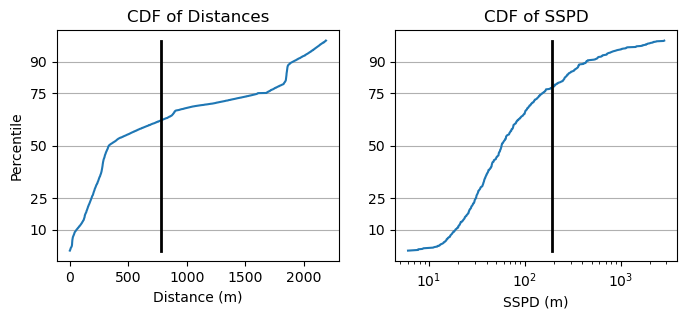

In [12]:
# CDF with percentiles
fig, axarr = plt.subplots(1,2)
fig.set_size_inches(8,3)

ax = axarr[0]
ax.plot(sorted(distances),np.linspace(0,1,len(distances))*100)
ax.plot([np.mean(distances)]*2, [0,100], 'k', lw=2)
ax.set_title('CDF of Distances')
ax.set_xlabel('Distance (m)')

ax = axarr[1]
ax.plot(sorted(sspd), np.linspace(0,1,len(sspd))*100)
ax.plot([np.mean(sspd)]*2, [0,100], 'k', lw=2)
ax.set_xscale('log')
ax.set_title('CDF of SSPD')
ax.set_xlabel('SSPD (m)')

for ax in axarr:
    ax.set_yticks([10,25,50,75,90])
    ax.grid(axis='y')
axarr[0].set_ylabel('Percentile')

# fig.subplots_adjust(wspace=0.3)

# Export

In [13]:
fname_out = '../data/jhw_2024-05-13/sample_sspds.csv'
pd.DataFrame(data={'sspd': np.array(sspd)}).to_csv(fname_out, index=False)

In [14]:
fname_out = '../data/jhw_2024-05-13/sample_distances.csv'
pd.DataFrame(data={'distance': np.array(distances)}).to_csv(fname_out, index=False)